# How to Solve System of ODEs
## DSC210, Group 11, Final Project

## Import Libraries:

In [1]:
import numpy as np
import pandas as pd
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from torch.autograd import Variable

## Data Generation:

In [2]:
# Define the Lotka-Volterra model
def lotka_volterra(y, t, alpha, beta, delta, gamma):
    prey, predator = y
    dydt = [alpha * prey - beta * prey * predator,
            delta * prey * predator - gamma * predator]
    return dydt

# Set fixed coefficients
alpha, beta, delta, gamma = 0.2, 0.02, 0.02, 0.4

# Initial conditions: Prey and Predator populations
initial_conditions = [20, 20]

# Time points
t = np.linspace(1, 100, 100)  # 100 time points

# Solve ODE
solution = odeint(lotka_volterra, initial_conditions, t, args=(alpha, beta, delta, gamma))

# Convert solution to a DataFrame
df = pd.DataFrame(solution, columns=['Prey', 'Predator'])
df['Time'] = t

# Save the DataFrame to a CSV file
file_path = 'lotka_volterra_data.csv'
df.to_csv(file_path, index=False)

file_path

'lotka_volterra_data.csv'

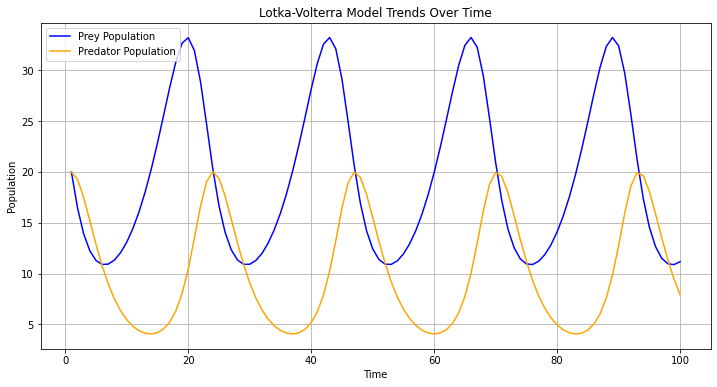

In [3]:
# Plotting the trends over time for the Lotka-Volterra model

plt.figure(figsize=(12, 6))

# Plotting prey and predator populations over time
plt.plot(df['Time'], df['Prey'], label='Prey Population', color='blue')
plt.plot(df['Time'], df['Predator'], label='Predator Population', color='orange')

# Plot settings
plt.title('Lotka-Volterra Model Trends Over Time')
plt.xlabel('Time')
plt.ylabel('Population')
plt.legend()
plt.grid(True)

plt.savefig('Generated_data.jpeg', dpi = 400)

plt.show()

In [4]:
# Set fixed coefficients
alpha, beta, delta, gamma = 0.2, 0, 0, 0.4

# Initial conditions: Prey and Predator populations
initial_conditions = [20, 20]

# Time points
t = np.linspace(1, 100, 100)  # 100 time points

# Solve ODE
solution = odeint(lotka_volterra, initial_conditions, t, args=(alpha, beta, delta, gamma))

# Convert solution to a DataFrame
df = pd.DataFrame(solution, columns=['Prey', 'Predator'])
df['Time'] = t

# Save the DataFrame to a CSV file
file_path = 'lotka_volterra_data_no_relationship.csv'
df.to_csv(file_path, index=False)

file_path

'lotka_volterra_data_no_relationship.csv'

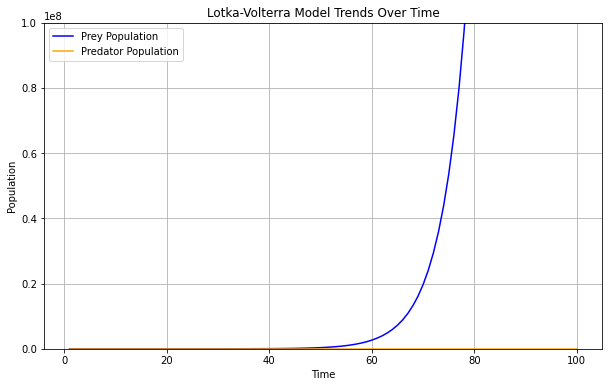

In [5]:
# Plotting the trends over time for the Lotka-Volterra model

plt.figure(figsize=(10, 6))

# Plotting prey and predator populations over time
plt.plot(df['Time'], df['Prey'], label='Prey Population', color='blue')
plt.plot(df['Time'], df['Predator'], label='Predator Population', color='orange')

# Plot settings
plt.title('Lotka-Volterra Model Trends Over Time')
plt.ylim(0,100000000)
plt.xlabel('Time')
plt.ylabel('Population')
plt.legend()
plt.grid(True)

plt.savefig('Generated_data_no_relationship.jpeg', dpi = 400)

plt.show()

## Method 1: Eigenvalue Method

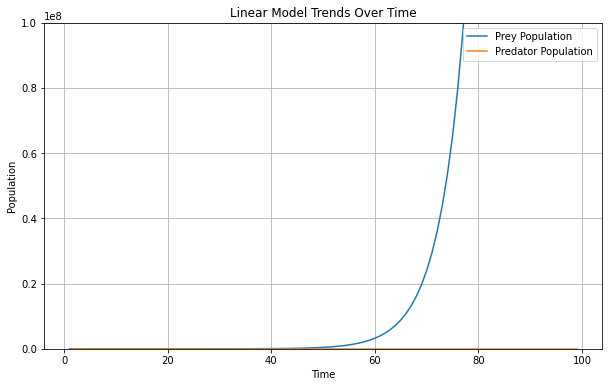

In [6]:
# Define initial conditions
x0 = np.array([20, 20])  # Replace with actual values

beta = -0
gamma = -0.4

x1 = x0[0] * beta
x2 = x0[1] * gamma
# Define the matrix A and compute eigenvalues and eigenvectors
A = np.array([[0.2, x1],
              [0, x2]])
eigenvalues, eigenvectors = np.linalg.eig(A)

# find the inverse matrix
Pin_inv = np.linalg.inv(eigenvectors)

# Define a function to compute x(t) for any t
def x(t):
    a = np.exp(eigenvalues[0] * t) * eigenvectors[:,0]
    b = np.exp(eigenvalues[1] * t) * eigenvectors[:,1]
    matrix1 = np.vstack((a, b)).T @ Pin_inv 
    matrix2 = x0.T
    #print(np.exp(eigenvalues[0] * t) * eigenvectors[:,0] + np.exp(eigenvalues[1] * t) * eigenvectors[:,1])
    return [np.sum(matrix1[0][0]*matrix2[0] + matrix1[0][1]*matrix2[1]), np.sum(matrix1[1][0]*matrix2[0] + matrix1[1][1]*matrix2[1])]

# Example: Compute x(t) at t = 1 (you can replace this with any t)

# Create an array of t values
t_values = np.arange(1, 100, 1)

# Compute x(t) for each t in the t_values array
trend = [x(t) for t in t_values]

# Extract the first and second components of the trend for plotting
x1_values = [x_t[0] for x_t in trend]
x2_values = [x_t[1] for x_t in trend]

# Plot x1(t) and x2(t) as functions of t
plt.figure(figsize=(10, 6))
plt.plot(t_values, x1_values, label='Prey Population')
plt.plot(t_values, x2_values, label='Predator Population')
plt.xlabel('Time')
plt.ylim(0,100000000)
plt.ylabel('Population')
plt.legend()
plt.title('Linear Model Trends Over Time')
plt.grid(True)

plt.savefig('Linear_model_No_Relationship.jpeg', dpi = 400)

## Method 2: RNN

In [7]:
# Check for available device
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_built() else "cpu")

print(device)

# Load the dataset
file_path = 'lotka_volterra_data.csv'
df = pd.read_csv(file_path)

# Normalize the data
scaler = MinMaxScaler(feature_range=(-1, 1))
df_scaled = scaler.fit_transform(df[['Prey', 'Predator']])

# Convert the dataset to PyTorch tensors
data = torch.FloatTensor(df_scaled).to(device)

mps


In [8]:
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq, train_label))
    return inout_seq

seq_length = 5  # number of previous time steps to consider
train_inout_seq = create_inout_sequences(data, seq_length)

# Define the RNN model
class RNN(nn.Module):
    def __init__(self, input_size=2, hidden_layer_size=10, output_size=2):
        super(RNN, self).__init__()
        self.hidden_layer_size = hidden_layer_size

        # Using ReLU activation in RNN layer
        self.rnn = nn.RNN(input_size, hidden_layer_size, nonlinearity='relu')

        self.linear = nn.Linear(hidden_layer_size, output_size)
        self.hidden_cell = torch.zeros(1,1,self.hidden_layer_size)

    def forward(self, input_seq):
        rnn_out, self.hidden_cell = self.rnn(input_seq.view(len(input_seq), 1, -1), self.hidden_cell)
        predictions = self.linear(rnn_out.view(len(input_seq), -1))
        
        return predictions[-1]

# Instantiate the model, define the loss function and the optimizer
model = RNN().to(device)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [9]:
# Set a random seed
seed = 3
torch.manual_seed(seed)

# Training the RNN
epochs = 20
losses = []

for i in range(epochs):
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size).to(device))

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    losses.append(single_loss.item())
    
    print(f'epoch: {i} loss: {single_loss.item():10.10f}')

/Users/jasonc/opt/anaconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 2])) that is different to the input size (torch.Size([2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch: 0 loss: 0.2175555974
epoch: 1 loss: 0.0427589193
epoch: 2 loss: 0.0050577028
epoch: 3 loss: 0.0021350966
epoch: 4 loss: 0.0007845148
epoch: 5 loss: 0.0009472583
epoch: 6 loss: 0.0008813403
epoch: 7 loss: 0.0007160731
epoch: 8 loss: 0.0012285890
epoch: 9 loss: 0.0004725798
epoch: 10 loss: 0.0000646708
epoch: 11 loss: 0.0262068193
epoch: 12 loss: 0.0007066724
epoch: 13 loss: 0.0012903968
epoch: 14 loss: 0.0086429929
epoch: 15 loss: 0.0061839130
epoch: 16 loss: 0.0006420521
epoch: 17 loss: 0.0015557557
epoch: 18 loss: 0.0162093677
epoch: 19 loss: 0.0155835347


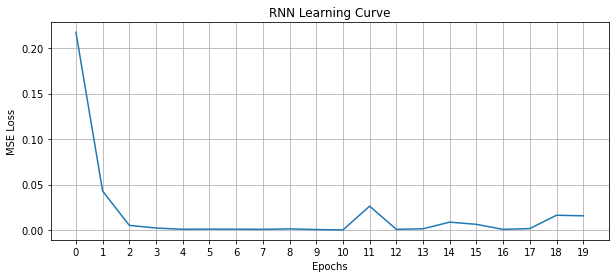

In [10]:
# Plotting the learning curve
plt.figure(figsize=(10,4))
plt.plot(range(epochs), losses)
plt.xticks(np.arange(0,20,1))
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.title('RNN Learning Curve')
plt.grid(True)

plt.savefig("Learning Curve.jpeg", dpi = 400)

plt.show()

In [11]:
# Save the trained model
model.to('cpu')
torch.save(model.state_dict(), 'ode_model.pth')

/Users/jasonc/opt/anaconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 2])) that is different to the input size (torch.Size([2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Test Loss: 0.014764936474200926


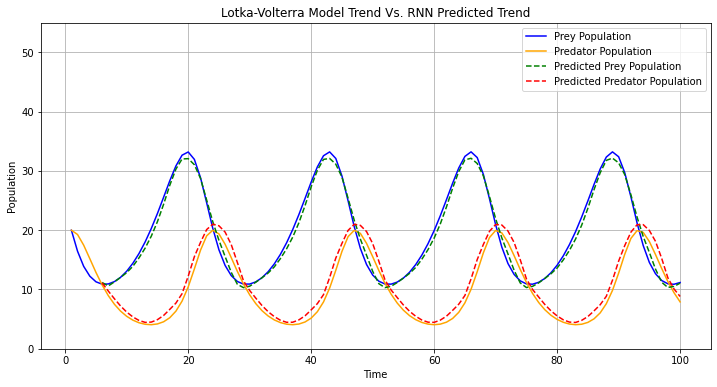

In [12]:
# Assuming the model and the scaler are already defined and trained

# Load the test data
test_df = pd.read_csv('lotka_volterra_data.csv')

# Normalize the test data
test_scaled = scaler.transform(test_df[['Prey', 'Predator']])
test_data = torch.FloatTensor(test_scaled).to(device)

# Prepare the test data sequences
test_sequences = create_inout_sequences(test_data, seq_length)

# Evaluate the model
model.eval()  # Set the model to evaluation mode
model.to(device)

test_loss = 0
predictions = []  # Store model predictions

with torch.no_grad():
    for seq, true_value in test_sequences:
        seq = seq.to(device)
        true_value = true_value.to(device)
        prediction = model(seq)
        test_loss += loss_function(prediction, true_value).item()
        predictions.append(prediction.cpu().numpy())  # Append predictions to the list

test_loss /= len(test_sequences)
print(f'Test Loss: {test_loss}')

# Reshape the predicted_data to a 2D array
predicted_data = np.concatenate(predictions, axis=0).reshape(-1, 2)

# Pad the beginning of predicted_data with NaN values to match the time values' length
num_nan_values = len(test_df['Time']) - len(predicted_data)
if num_nan_values > 0:
    nan_values = np.full((num_nan_values, 2), np.nan)
    predicted_data = np.concatenate([nan_values, predicted_data], axis=0)

# Inverse-transform the scaled predictions back to the original scale
predicted_data = scaler.inverse_transform(predicted_data)

# Plotting the trends over time for the Lotka-Volterra model
plt.figure(figsize=(12, 6))
    
# Plotting prey and predator populations over time
plt.plot(test_df['Time'], test_df['Prey'], label='Prey Population', color='blue')
plt.plot(test_df['Time'], test_df['Predator'], label='Predator Population', color='orange')

# Plotting the model's predicted trend
plt.plot(test_df['Time'], predicted_data[:, 0], label='Predicted Prey Population', linestyle='--', color='green')
plt.plot(test_df['Time'], predicted_data[:, 1], label='Predicted Predator Population', linestyle='--', color='red')

# Plot settings
plt.title('Lotka-Volterra Model Trend Vs. RNN Predicted Trend')
plt.ylim(0,55)
plt.xlabel('Time')
plt.ylabel('Population')
plt.legend(loc = 'upper right')
plt.grid(True)
    
plt.savefig("RNN Simulation Results.jpeg", dpi = 400)
    
plt.show()